# Reproduction Number
The purpose of this notebook is to compute the basic reproduction number at the onset of an epidemic or at the beginning of a following wave in case no actions have been taken to reduce the spread of an infection. We base our discussion on the [Susceptible-Infectious-Recovered (SIR)](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) model and we make some assumptions to simplify the computation of the parameters we want to estimate. We start from the set of differential equations of the SIR model

$$ \frac{dS}{dt} = -\frac{\beta IS}{N} $$ &nbsp;


$$ \frac{dI}{dt} = \frac{\beta IS}{N} -\gamma I $$ &nbsp;


$$ \frac{dR}{dt} = \gamma I $$ &nbsp;

where N is the population, S the number of susceptible individuals, I the number of infected individuals and R the number of individuals who have recovered or are dead. The parameter $\beta$ represents the number of individuals who get infected from another infected indivdual in the unit time (e.g. one day). The parameter $\gamma$ represents the rate at which an individual recovers from the illness or die and it's the reciprocal of the time $\tau$ it takes. It is important to note that $\gamma$ depends on the illness itself and once estimated it won't change while $\beta$ depends also on the actions that are taken to stop the disease for example by reducing contacts among individuals or using some tools, like masks, to reduce the spread of the infection. 

## Simplifying assumptions
At the onset of the epidemic the number of susceptibles S is the entire population and it decreases as long as individuals become infected and then they recover or die. We assume that at the onset S does not change very much and we assume S practically constant for some time, from the onset of the epidemic till some action is taken or a relevant fraction of the population has been infected. With this assumption we can focus on the differential equation of the infections

$$\frac{dI}{dt} = (\frac{\beta S}{N} -\gamma) I$$

We introduce the basic reproduction number $R_0$ that represents the number of secondary infections that one infected individual can make before it is removed from the infected group because of recovering or death. 

$$R_0 = \frac{\beta}{\gamma}$$

The differential equation for the infections becomes

$$\frac{dI}{dt} = (\frac{R_0 S}{N} - 1)\gamma I$$

that can be easily solved analitically by integration

$$\frac{dI}{I} = (\frac{R_0 S}{N} - 1)\gamma dt$$

so that

$$log(I(t)) = log(I_0) +  (\frac{R_0 S}{N} - 1)\gamma t$$

With our simplifying assumptions, the logarithm of the number of infections should follow a linear function 

$$y = log(I(t)) = b + at$$

with slope 

$$a = (\frac{R_0 S}{N} - 1)\gamma $$

and intercept

$$b = log(I_0)$$

In the following sections of the notebook, as an example, we'll use the data of the confirmed infections for Italy to fit the linear approximation and find out the value of the intercept from which we will be able to compute the value of $R_0$. We assume $\tau = \frac{1}{\gamma}$ to be 14 days since this is the number of days that has been established in which an individual infected by the covid-19 is infectious. 

## Python packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')
from platform import python_version
print("python version: %s"%python_version())
print("numpy version: %s"%np.__version__)
print("pandas version: %s"%pd.__version__)
print("matplotlib version: %s"%mpl.__version__)

python version: 3.8.2
numpy version: 1.18.1
pandas version: 1.0.2
matplotlib version: 3.3.1


## Data source
As an example we use the data from the Johns Hopkins Center for Systems Science and Engineering (CSSE) about the spread of the covid-19 infections for Italy.

In [26]:
#url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
confirmed_dataset = pd.read_csv(url_confirmed) 
# creates an index of dates
start_date_index = 43 # starts from March 1st
end_date_index = len(confirmed_dataset.columns) 
start_day = pd.to_datetime(confirmed_dataset.columns[start_date_index]).strftime('%Y-%m-%d')
end_day = pd.to_datetime(confirmed_dataset.columns[end_date_index - 1]).strftime('%Y-%m-%d')
date_index = pd.date_range(start_day, end_day)
week_index = pd.date_range(start_day, end_day, freq='W')
date_index_array = [date.strftime('%Y-%m-%d') for date in date_index] # dates array used for plotting
print("Start date: {0:4s}, end date: {1:4s} ".format(start_day, end_day))

Start date: 2020-03-01, end date: 2020-11-03 


### Cumulative confirmed infections
The number of infected individuals in a certain day is the sum of all the confirmed infected individuals from the onset of the epidemic up to that day.

In [5]:
confirmed_dataset_it = confirmed_dataset[confirmed_dataset['Country/Region'] == 'Italy']
confirmed_dataset_values_it = [confirmed for confirmed in confirmed_dataset_it.values[0][start_date_index:]] 
confirmed_infections_it = pd.Series(confirmed_dataset_values_it, index=date_index)
confirmed_infections_it['2020-11-01':]

2020-11-01    709335.0
2020-11-02    731588.0
2020-11-03    759829.0
Freq: D, dtype: float64

In [6]:
confirmed_per_day_array_it = [confirmed_infections_it[d++1] - confirmed_infections_it[d] for d in range(date_index.size - 1)]
confirmed_per_day_it = pd.Series(confirmed_per_day_array_it, index=date_index[1:])
confirmed_per_day_it['2020-11-01':]

2020-11-01    29905.0
2020-11-02    22253.0
2020-11-03    28241.0
Freq: D, dtype: float64

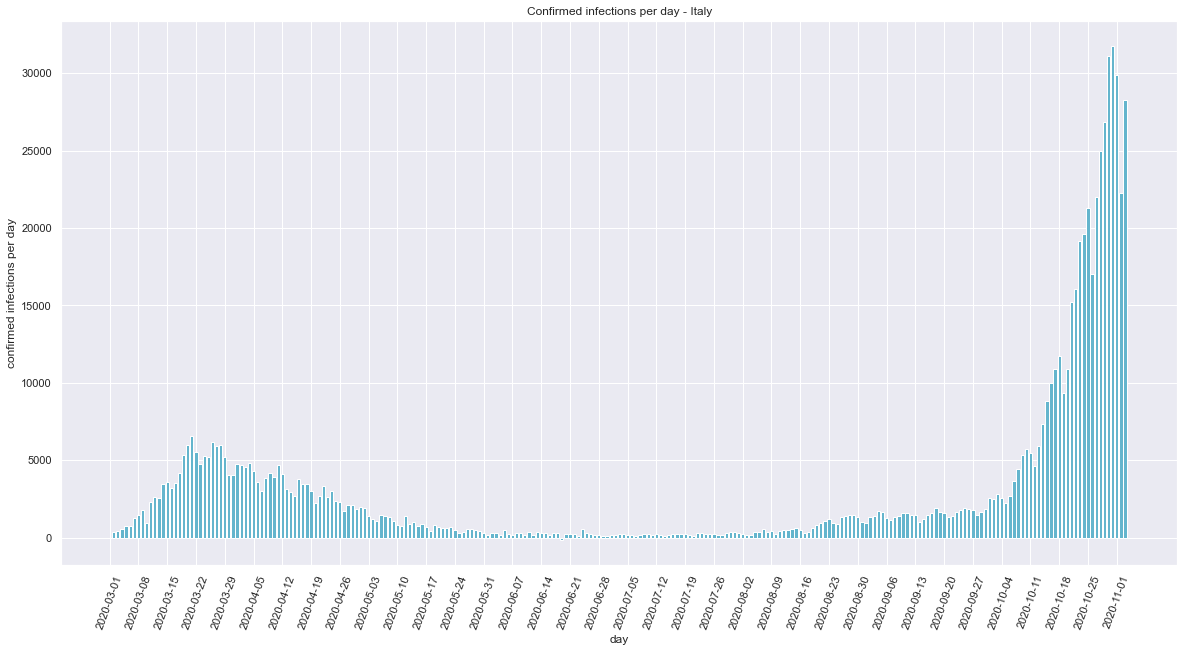

In [7]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Confirmed infections per day - Italy")
ax.set_xlabel("day")
ax.set_ylabel("confirmed infections per day");
ax.set_xticks(week_index)
ax.set_xticklabels(week_index, rotation=70)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.bar(date_index_array[1:], confirmed_per_day_array_it, color='c')
plt.savefig('confirmed-infections-italy.png')

We use the data at the onset of the 2nd wave of the infection to compute the value of $R_0$. Looking at the plot, one good point to start seems to be the middle of August. We assume that no action has been taken yet to stop the spread of the infection. 

In [17]:
import math
log_confirmed = [math.log(confirmed) for confirmed in confirmed_per_day_array_it[165:]]
days = len(log_confirmed)
days

82

In [16]:
import numpy as np
from scipy.optimize import curve_fit

We will use the last 30 days of data to estimate the intercept of our linear model

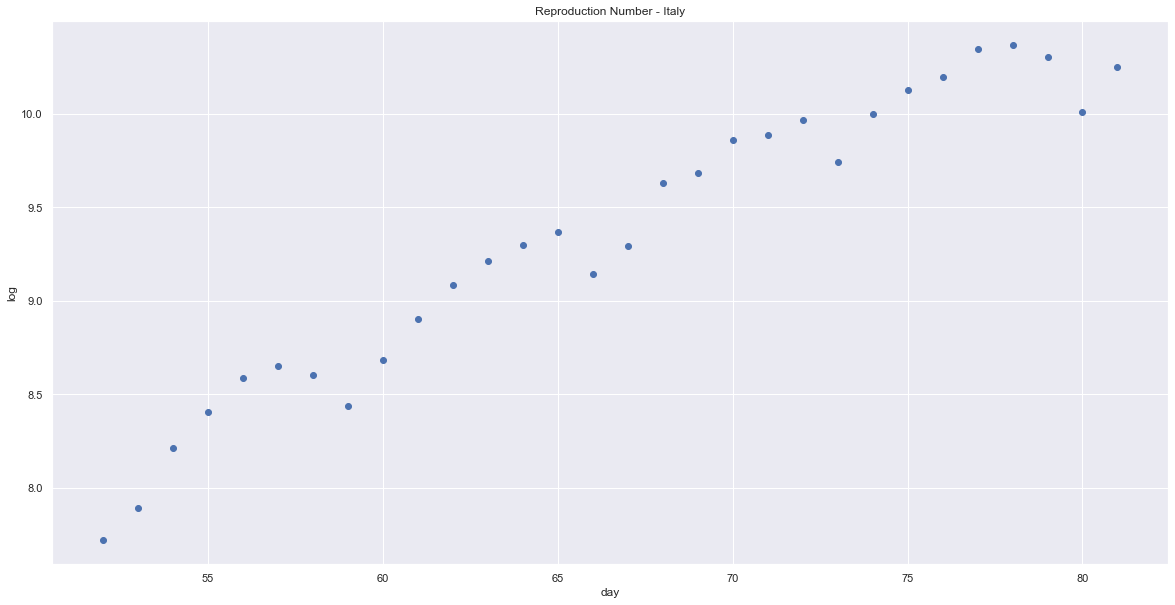

In [19]:
days_estimation = 30
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Reproduction Number - Italy")
ax.set_xlabel("day")
ax.set_ylabel("log");
x = np.arange(days - days_estimation, days,1)
y = log_confirmed[days - days_estimation:days]
plt.plot(x, y, 'o')

## Linear approximation
We fit the data using a linear model to find out the value of the intercept and its error.

In [21]:
def linearfunc(x, a, b):
    return a * x + b 

In [22]:
popt, pcov = curve_fit(linearfunc, x, y) # estimates the parameters of the linear function a, b
a = popt[0]
b = popt[1]
print(a, b)
perr = np.sqrt(np.diag(pcov))
error_a = perr[0]
error_b = perr[1]
print(error_a, error_b)

0.08534202078633224 3.65312585904188
0.00402190570567528 0.2697126861738437


Now we can plot the linear function that fits the data of the infection in the last 30 days after the onset of the 2nd wave of epidemic.

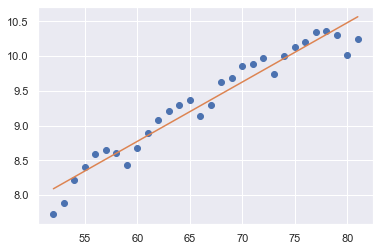

In [23]:
yfit = linearfunc(x, a, b)
plt.plot(x, y, 'o')
plt.plot(x,yfit)

The linear function seems to fit the data pretty well. Now we can use the relation between the intercept and the parameters of the differential equation for the infections to compute 

$$R_0 = \frac{N}{S}(a \tau + 1)$$

In [31]:
N = 60000000 # Italian population
tau = 14
S = N - confirmed_infections_it[end_day] # susceptibles
R = (N / S) * (a * tau + 1)
R

2.2229391853125993

We can see that the value is quite reasonable and within the [interval reported in some scientific papers](https://en.wikipedia.org/wiki/Basic_reproduction_number).